In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from sim import Simulator, SimConfig
from miners.repay_proportional import RepayProportionalShortfallMinerState
from miners.burn import BurnShortfallMinerState
from miners.repay_ratchet import RepayRatchetShortfallMinerState
from miners.base import BaseMinerState
from network import *
from strategy import *
from consts import *

import dataclasses
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
from functools import partial
import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import jax.numpy as jnp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random

from tqdm.auto import tqdm
import seaborn as sns
from ipywidgets import *

import pickle
import os

In [11]:
def show_miner_accounting_charts(df):
#     plt.figure()
    fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True, figsize=(9, 4))

    # Balance sheet
    ax1.grid(axis='y', color='#EEE')
    ax1.plot(df['day'], df['net_equity'], label="Net equity")
    ax1.plot(df['day'], df['balance'], label="Balance")
    ax1.plot(df['day'], df['available'], '--', label="Available")
    ax1.plot(df['day'], -df['lease'], label="Lease")
    ax1.plot(df['day'], df['pledge_locked'], '--', label="Pledge locked")
    ax1.set_title("Miner equity")
    ax1.set_xlabel("Day")
    ax1.set_ylabel("FIL")
    ax1.legend()

    # PnL
    ax2.grid(axis='y', color='#EEE')
    ax2.plot(df['day'], df['reward_earned'], label="Rewards")
    ax2.plot(df['day'], -df['fee_burned'], label="Shortfall fee")
    ax2.plot(df['day'], -df['lease_fee_accrued'], label="Lease fee")
#     ax2.plot(df['day'], df['reward_earned'] - (df['fee_burned'] + df['lease_fee_accrued']),
#             label='Rewards-[Shortfall+Lease]')
    ax2.set_title("Miner Net Returns [CumSum?]")
    ax2.set_xlabel("Day")
    ax2.legend()

    plt.show()

def compare_configurations(cfgs, title, days, stats_interval=DAY):
    statss = {label: pd.DataFrame(Simulator(cfg).run_all(days, stats_interval)) for (label, cfg) in cfgs.items()}

    plt.grid(axis='y', color='#EEE')
    for label, df in statss.items():
        plt.plot(df['day'], df['net_equity'], label=label)

    plt.plot()
    plt.title("Miner equity - " + title)
    plt.xlabel("Day")
    plt.ylabel("FIL")
    plt.legend()
    plt.show()

## Repay the shortfall

In [5]:
days = 3 * YEAR + 1
stats_interval = DAY

In [13]:
def run_sim(x):
    initial_pledge_projection_period_days = x[0]
    supply_lock_target = x[1]
    token_lease_fee = x[2]
    max_repayment_term = x[3]
    max_fee_reward_fraction = x[4]

    network = dataclasses.replace(MAINNET_APR_2023,
        token_lease_fee=token_lease_fee,
        reward_decay=REWARD_DECAY, # or try REWARD_DECAY + BASELINE_GROWTH
        initial_pledge_projection_period_days=initial_pledge_projection_period_days,
        supply_lock_target=supply_lock_target
    )

    miner_factory = RepayRatchetShortfallMinerState.factory(
        balance=0,
        max_repayment_term=max_repayment_term,
        max_fee_reward_fraction=max_fee_reward_fraction,
        reward_projection_decay=REWARD_DECAY + BASELINE_GROWTH
    )
    cfg = SimConfig(
        network=network,
        strategy=StrategyConfig.pledge_limited(1000.0, 3 * YEAR, True),
        miner_factory=miner_factory,
    )
    stats = Simulator(cfg).run_all(days, stats_interval)
    return stats

In [14]:
x_in = jnp.array([20.0, 0.3, 0.2, 3.*365, 0.25])
stats_df = pd.DataFrame(data=run_sim(x_in))

<IPython.core.display.Javascript object>


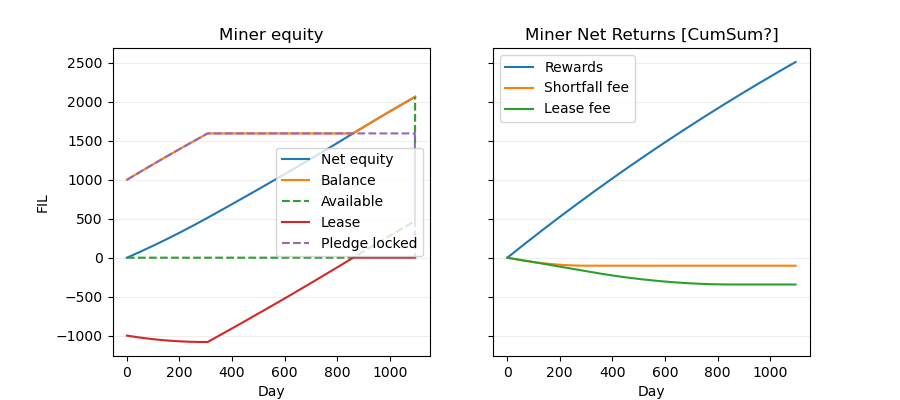

In [15]:
show_miner_accounting_charts(stats_df)

In [16]:
# from:  https://github.com/google/jax/issues/3171#issuecomment-1140299630
@partial(jit, static_argnums=(1,))
def moving_window(a, size: int):
    starts = jnp.arange(len(a) - size + 1)
    return vmap(lambda start: jax.lax.dynamic_slice(a, (start,), (size,)))(starts)

def jax_wrapper(x):
    stats = run_sim(x)
    
    # JAX doesn't like DataFrames, so we extract the output quantity that we're interested in directly
    # from the dictionary

#     returns_raw = jnp.array([(x['reward_earned'] - (x['fee_burned'] + x['lease_fee_accrued'])) 
#                             for x in stats])
    # i think these are cumulative quantities rather than by "day" quantities,
    # so we need to index at the right time to get the total returns rather than window-sum
#     returns_1y = jnp.sum(moving_window(returns_raw, 365), axis=1)
#     return returns_1y

    indices = np.arange(365, len(stats), 365)
    returns_raw = [(stats[ii]['reward_earned'] - (stats[ii]['fee_burned'] + stats[ii]['lease_fee_accrued'])) 
                   for ii in indices]
                
    returns_raw = jnp.array(returns_raw)
    return returns_raw

jacobian = jacfwd(jax_wrapper)  # forward mode differentiation seems faster
# jacobian2 = jacrev(jax_wrapper)  # seems slower on initial timing

In [21]:
initial_pledge_projection_period_days_vec = np.arange(18,23,1).astype(np.float32)
supply_lock_target_vec = np.asarray([0.3, 0.4, 0.5])
token_lease_fee_vec = np.arange(0.18, 0.22, 0.01)
max_repayment_term_vec = np.asarray([900, 365*3, 1300]).astype(np.float32)
max_fee_reward_fraction_vec = np.asarray([0.23, 0.24, 0.25, 0.26, 0.27]).astype(np.float32)

results_dict = {}
pbar = tqdm(total = 
            len(initial_pledge_projection_period_days_vec)*
            len(supply_lock_target_vec)*
            len(token_lease_fee_vec) *
            len(max_repayment_term_vec) * 
            len(max_fee_reward_fraction_vec)
)
for initial_pledge_projection_period_days in initial_pledge_projection_period_days_vec:
    for supply_lock_target in supply_lock_target_vec:
        for token_lease_fee in token_lease_fee_vec:
            for max_repayment_term in max_repayment_term_vec:
                for max_fee_reward_fraction in max_fee_reward_fraction_vec:
                    x_in = jnp.asarray([initial_pledge_projection_period_days, 
                                        supply_lock_target,
                                        token_lease_fee]).astype(jnp.float32)
                    jc = jacobian(x_in)
                    key = '%0.03f,%0.03f,%0.03f,%0.03f,%0.03f' % (
                        initial_pledge_projection_period_days,
                        supply_lock_target,
                        token_lease_fee,
                        max_repayment_term,
                        max_fee_reward_fraction,
                    )
                    results_dict[key] = np.asarray(jc)
                    pbar.update(1)

  0%|          | 0/1125 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
results_dir = 'results'
os.makedirs(results_dir, exist_ok=True)

In [ ]:
# store results
with open(os.path.join(results_dir, 'jacobians_repay_ratchet.pkl'), 'wb') as f:
    pickle.dump(results_dict, f)

In [ ]:
with open(os.path.join(results_dir, 'jacobians_repay_ratchet.pkl'), 'rb') as f:
    results_dict = pickle.load(f)

In [ ]:
def get_closest_index(val, arr):
    idx = (np.abs(arr-val)).argmin()
    return idx   

def f(ipppd, lt, tlf, mrt, mfrf):
    # find closest indices
    ipppd_idx = get_closest_index(ipppd, initial_pledge_projection_period_days_vec)
    lt_idx = get_closest_index(lt, supply_lock_target_vec)
    tlf_idx = get_closest_index(tlf, token_lease_fee_vec)
    _idx = get_closest_index(lt, max_repayment_term_vec)
    _idx = get_closest_index(tlf, max_fee_reward_fraction_vec)
    
    
    # generate dictionary key
    key = '%0.03f,%0.03f,%0.03f' % (
                initial_pledge_projection_period_days_vec[ipppd_idx],
                supply_lock_target_vec[lt_idx],
                token_lease_fee_vec[tlf_idx]
            )
    # get jacobian
    jc = results_dict[key]
    
    return jc

fig, ax = plt.subplots()
def update(ipppd=20, lt=0.3, tlf=0.2):
    new_data = f(ipppd, lt, tlf)
    im.set_array(new_data)
    fig.canvas.draw_idle()
    
jc = f(20, 0.3, 0.2)
im = ax.imshow(jc)
fig.colorbar(im)

interact(update, ipppd = (18,23,1), lt = (0.3,0.5,0.1), tlf = (0.18,0.22,0.01))